# ch19_3 text classification

이미지와 마찬가지로 텍스트 데이터도 분류가 가장 기본적인 테스크입니다. 긍정적인 리뷰와 부정적인 리뷰로 분류하는 모델을 만들어보겠습니다.

## 사전 작업

### 데이터 셋 준비

### tokenizer 준비

## 데이터 전처리

텍스트 데이터 셋도 이미지 데이터 셋과 마찬가지로 dataset과 dataloader가 필요합니다. 그리고 텍스트를 텐서로 변환하는 전처리 로직도 필요합니다. 우선 간단하게 dataset과 dataloader를 만들어주겠습니다.

### Dataset, DataLoader

텍스트 데이터의 특징은 문장들 간에 길이가 다르다는 것입니다. 즉, 문장을 토큰화화면 길이가 달라집니다. 배치에 들어있는 텍스트 데이터를 토큰화 해보겠습니다.

### Padding

위 예시에서 data loader가 batch size만큼 문장을 읽어왔습니다. 그리고 이를 토큰화 하였는데, 문장마다 길이가 다르기 때문에 토큰 개수도 다릅니다. 이를 하나의 텐서로 묶어주기 위해서는 가장 긴 문장의 길이를 기준으로 나머지 문장들에 패딩을 추가해주어야 합니다. 

먼저 패딩에 해당하는 토큰을 확인해보겠습니다.

torch에 내장되어 있는 pad_sequence 기능을 이용해서 패딩을 채워보겠습니다.

패딩을 채워보면 하나의 열에 문장 하나의 토큰 값들이 담기게 됩니다. 가장 긴 문장의 길이만큼 나머지 문장들에는 패딩이 채워진 모습을 확인할 수 있습니다.

### collate_fn

이렇게 텍스트를 토큰화 하고, 배치 단위로 패딩을 채워넣었습니다. 그런데 패딩을 채우기 위해서는 배치 내에서 가장 길이가 긴 문장의 토큰 수를 알아야 합니다. 즉, 데이터 셋에서 데이터 로더가 배치 사이즈만큼 데이터를 가져오는 시점에 텍스트를 토큰화하고, 패딩을 채우는 작업을 수행해주어야 합니다. 이러한 작업을 수행해주는 역할을 묶어주는 함수, collate_fn이라고 부릅니다.

collate 함수 안에서는 데이터를 토큰화 해주고, 패딩을 채워주는 작업을 진행합니다. 이 때, 특정 문장의 길이가 지나치게 긴 경우를 예방하기 위해 최대 토큰 길이 값을 지정해줍니다.

## 모델 학습

### 모델 작성

이제 텍스트를 분류하는 딥러닝 모델을 만들어보겠습니다. 모델의 구조는 아래와 같습니다.

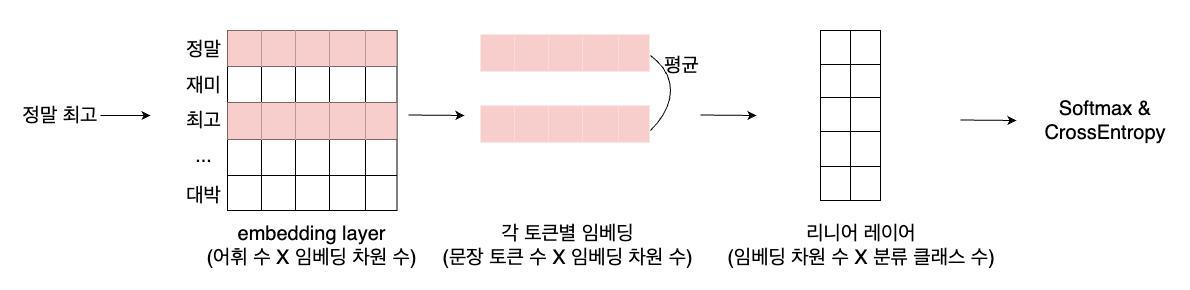

먼저 토큰화 한 문장을 embedding layer를 통과시켜 각 토큰별 임베딩 벡터를 가져옵니다. 각 토큰별로 128 차원의 임베딩을 갖도록 하고, 현재 tokenizer는 총 8000개의 토큰을 가지고 있으므로 임베딩 레이어는 8000 X 128이 됩니다. 이제 문장에 포함된 토큰만 가져온 뒤, 평균을 냅니다. 그리고 이를 리니어 레이어를 하나 통과시킨 뒤, 학습을 시켜보겠습니다. 

### 학습 코드 준비

기존 모델 학습에 사용했던 코드를 재사용하여 학습을 진행해보겠습니다.

In [ ]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [370]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score


def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train in tqdm(train_dataloader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        acc = ((y_train == pred).sum() / len(y_train)).item()
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [371]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val in tqdm(val_dataloader):
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())

            pred = torch.argmax(outputs, dim=1)
            acc = ((y_val == pred).sum() / len(y_val)).item()
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [372]:
from collections import defaultdict


def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch {epoch + 1} train - loss: {train_loss} acc: {train_acc} val - loss: {val_loss} acc: {val_acc}")
    return logs

In [376]:
from matplotlib import pyplot as plt

def plot_logs(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

### 하이퍼 파라미터 셋팅 

### 학습

## 정리

이번 챕터에서는 텍스트 데이터를 DataLoader를 이용해서 텐서로 변환하고, Embedding Layer와 Fully Connected Layer를 이용해서 분류 모델을 학습시키는 작업을 수행해보았습니다. 그 결과 84% 정도의 성능을 얻을 수 있었습니다.